In [31]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os

#connecting/creating local db
conn = sqlite3.connect("fintech.db")

#loading excel file
df = pd.read_excel("data/transaction.xlsx")

#write to sql from csv
df.to_sql("transactions", conn, if_exists="replace", index=False)


100006

In [70]:
#defining the baseline amount for customers from their avg expenditures
amount_baseline = pd.read_sql("Select Distinct Customer_ID, avg(Amount_in_euros) as avg_Amount from transactions where Amount_in_euros IS NOT NULL group by Customer_ID", conn)

In [72]:
#defining the frequency of transactions per day by the customers
frequency_baseline = pd.read_sql("SELECT Customer_ID, COUNT(*) * 1.0 / COUNT(DISTINCT Date) AS avg_frequency FROM transactions WHERE Amount_in_euros IS NOT NULL GROUP BY Customer_ID", conn)

In [74]:
#defining the region of transactions by the customers
region_baseline = pd.read_sql("SELECT Customer_ID, Country_of_Transaction, COUNT(*)* 1.0 / SUM(COUNT(*)) OVER (Partition by Customer_ID) AS region_ratio FROM transactions WHERE Amount_in_euros IS NOT NULL GROUP BY Customer_ID, country_of_transaction", conn)

In [76]:
trnx_df = pd.read_sql("SELECT * FROM transactions WHERE Customer_ID IS NOT NULL", conn)

In [78]:
df_clean = df.dropna(subset=["Customer_ID", "Country_of_Transaction", "Amount_in_euros"])
df_clean[["Customer_ID", "Country_of_Transaction"]].isna().sum()

Customer_ID               0
Country_of_Transaction    0
dtype: int64

In [80]:
region_baseline[["Customer_ID", "Country_of_Transaction"]].isna().sum()
trnx_withregion = df_clean.merge(region_baseline, on=["Customer_ID", "Country_of_Transaction"], how="left")

In [82]:
trnx_withregion.shape
df_clean.shape

(100006, 10)

In [84]:
trnx_withregion["region_ratio"].isna().sum()

0

In [86]:
# inverse scaled score
trnx_withregion["RegionScore"] = 1 - trnx_withregion["region_ratio"]

# Rescaling to 0–1 range
min_score = trnx_withregion["RegionScore"].min()
max_score = trnx_withregion["RegionScore"].max()
trnx_withregion["RegionScore"] = (trnx_withregion["RegionScore"] - min_score) / (max_score - min_score)

# Boosting score if Country_of_Transaction != Country_of_Residence
trnx_withregion.loc[
    trnx_withregion["Country_of_Transaction"] != trnx_withregion["Country_of_Residence"],
    "RegionScore"
] += 0.2

# Clipping final score to 0–1
trnx_withregion["RegionScore"] = trnx_withregion["RegionScore"].clip(0, 1)

In [88]:
trnx_withregion["RegionScore"].describe()

count    100006.000000
mean          0.715932
std           0.130296
min           0.105560
25%           0.636260
50%           0.721303
75%           0.806368
max           1.000000
Name: RegionScore, dtype: float64

In [90]:
trnx_withregion.sort_values("RegionScore", ascending=False).head()

,Transaction_ID,Date,Time,Customer_ID,Amount_in_euros,Merchant Group,Country_of_Transaction,Country_of_Residence,Bank,Timestamp,region_ratio,RegionScore
15266,#3412 991,2020-10-20,17:00:00,CUSTBAR604,25,Services,Switzerland,Mangolia,RBS,2020-10-20 17:00:00,0.011765,1.0
50657,#2679 475,2020-10-24,09:00:00,CUSTBAR806,25,Gaming,France,Mangolia,Barlcays,2020-10-24 09:00:00,0.011905,1.0
57178,#3222 161,2020-10-22,06:00:00,CUSTBAR437,36,Services,Mangolia,China,Monzo,2020-10-22 06:00:00,0.009901,1.0
29208,#2636 333,2020-11-03,15:00:00,CUSTBAR611,289,Subscription,Russia,USA,Barclays,2020-11-03 15:00:00,0.009960,1.0
3969,#2615 920,2020-11-06,18:00:00,CUSTMET587,121,Products,Mexico,Mangolia,Monzo,2020-11-06 18:00:00,0.008197,1.0


In [92]:
trnx_withregion.sort_values("RegionScore", ascending=False).tail()

,Transaction_ID,Date,Time,Customer_ID,Amount_in_euros,Merchant Group,Country_of_Transaction,Country_of_Residence,Bank,Timestamp,region_ratio,RegionScore
78401,#2984 233,2020-10-27,20:00:00,CUSTBAR548,196,Gaming,China,China,Barlcays,2020-10-27 20:00:00,0.049020,0.118083
99586,#2711 917,2020-11-11,20:00:00,CUSTMET967,64,Products,Russia,Russia,Barclays,2020-11-11 20:00:00,0.049689,0.105560
71395,#3245 065,2020-11-10,09:00:00,CUSTMET967,81,Fashion,Russia,Russia,Monzo,2020-11-10 09:00:00,0.049689,0.105560
17719,#2840 546,2020-10-14,05:00:00,CUSTMET967,36,Entertainment,Russia,Russia,HSBC,2020-10-14 05:00:00,0.049689,0.105560
14422,#2910 576,2020-10-13,14:00:00,CUSTMET967,144,Subscription,Russia,Russia,Lloyds,2020-10-13 14:00:00,0.049689,0.105560


In [94]:
# Merging customer baseline into transactions
trnx_withamount = trnx_withregion.merge(
    amount_baseline, on="Customer_ID", how="left"
)

In [98]:
#relative deviation from baseline
#trnx_withamount["AmountDeviation"] = abs(
#    trnx_withamount["Amount_in_euros"] - trnx_withamount["avg_Amount"]
#) / trnx_withamount["avg_Amount"]***

# relative deviation
trnx_withamount["AmountDeviation"] = abs(trnx_withamount["Amount_in_euros"] - trnx_withamount["avg_Amount"]) / trnx_withamount["avg_Amount"]

# apply a sigmoid-like scaling
trnx_withamount["AmountScore"] = 1 - np.exp(-trnx_withamount["AmountDeviation"])

In [100]:
# Converting deviation into AmountScore (0-1)
# Linear cap at 1.0
#trnx_withamount["AmountScore"] = trnx_withamount["AmountDeviation"].clip(0, 1)

In [102]:
# boosting score for extremely high amounts
trnx_withamount.loc[trnx_withamount["Amount_in_euros"] > 2*trnx_withamount["avg_Amount"], "AmountScore"] += 0.1
trnx_withamount["AmountScore"] = trnx_withamount["AmountScore"].clip(0, 1)

In [104]:
print(trnx_withamount["AmountScore"].describe())
trnx_withamount.sort_values("AmountScore", ascending=False).head()

count    100006.000000
mean          0.495364
std           0.226502
min           0.000723
25%           0.345830
50%           0.533691
75%           0.621831
max           1.000000
Name: AmountScore, dtype: float64


,Transaction_ID,Date,Time,Customer_ID,Amount_in_euros,Merchant Group,Country_of_Transaction,Country_of_Residence,Bank,Timestamp,region_ratio,RegionScore,avg_Amount,AmountDeviation,AmountScore
35602,#3398 261,2020-11-09,21:00:00,CUSTBAR166,37249,Subscription,Pakistan,Mexico,RBS,2020-11-09 21:00:00,0.034351,0.592306,218.034351,169.840053,1.0
68030,#2694 574,2020-10-31,20:00:00,CUSTLLO869,27225,Services,Ireland,India,Metro,2020-10-31 20:00:00,0.046122,0.372260,224.014675,120.532217,1.0
20173,#3640 154,2020-11-13,18:00:00,CUSTLLO489,18225,Entertainment,Greenland,Russia,Barlcays,2020-11-13 18:00:00,0.021782,0.827280,190.459406,94.689682,1.0
71384,#2839 495,2020-10-24,21:00:00,CUSTBAR558,2704,Electronics,South Africa,Russia,Halifax,2020-10-24 21:00:00,0.034137,0.596318,145.006024,17.647501,1.0
35040,#3453 986,2020-10-15,18:00:00,CUSTMET850,2116,Entertainment,Egypt,Russia,HSBC,2020-10-15 18:00:00,0.023941,0.786920,149.657459,13.138955,1.0


In [106]:
trnx_withamount.sort_values("AmountScore", ascending=False).tail()

,Transaction_ID,Date,Time,Customer_ID,Amount_in_euros,Merchant Group,Country_of_Transaction,Country_of_Residence,Bank,Timestamp,region_ratio,RegionScore,avg_Amount,AmountDeviation,AmountScore
12352,#3184 836,2020-11-07,14:00:00,CUSTBAR546,144,Services,Spain,Mangolia,Metro,2020-11-07 14:00:00,0.022727,0.809611,144.104167,0.000723,0.000723
65027,#3143 294,2020-11-08,16:00:00,CUSTBAR546,144,Gaming,United Kingdom,India,Barclays,2020-11-08 16:00:00,0.018939,0.880425,144.104167,0.000723,0.000723
96932,#3218 662,2020-11-12,16:00:00,CUSTBAR546,144,Fashion,Mozambique,United Kingdom,Barlcays,2020-11-12 16:00:00,0.022727,0.809611,144.104167,0.000723,0.000723
87244,#3633 075,2020-10-20,07:00:00,CUSTBAR546,144,Entertainment,Jordan,Sri Lanka,RBS,2020-10-20 07:00:00,0.035985,0.561764,144.104167,0.000723,0.000723
95147,#2701 459,2020-11-11,16:00:00,CUSTBAR546,144,Products,Poland,Bhutan,Monzo,2020-11-11 16:00:00,0.032197,0.632578,144.104167,0.000723,0.000723


In [108]:
# relative frequency deviation
frequency_baseline["FrequencyScore"] = 1 - frequency_baseline["avg_frequency"]/frequency_baseline["avg_frequency"].max()

trnx_final = trnx_withamount.merge(
    frequency_baseline[["Customer_ID", "FrequencyScore"]],
    on="Customer_ID",
    how="left"
)

In [110]:
# Defining weights
w1, w2, w3 = 0.4, 0.3, 0.3

trnx_final["ChangeScore"] = (
    w1 * trnx_final["RegionScore"] +
    w2 * trnx_final["FrequencyScore"] +
    w3 * trnx_final["AmountScore"]
)

In [112]:
trnx_final["ChangeScore"] = trnx_final["ChangeScore"].clip(0, 1)

In [114]:
# Summary statistics
print(trnx_final["ChangeScore"].describe())

# Top flagged transactions
trnx_final.sort_values("ChangeScore", ascending=False).head()

count    100006.000000
mean          0.625677
std           0.090878
min           0.288345
25%           0.563814
50%           0.630891
75%           0.689466
max           0.905855
Name: ChangeScore, dtype: float64


,Transaction_ID,Date,Time,Customer_ID,Amount_in_euros,Merchant Group,Country_of_Transaction,Country_of_Residence,Bank,Timestamp,region_ratio,RegionScore,avg_Amount,AmountDeviation,AmountScore,FrequencyScore,ChangeScore
262,#3413 096,2020-11-09,20:00:00,CUSTBAR235,1366561,Miscellaneos,Peru,Argentina,RBS,2020-11-09 20:00:00,0.002096,1.000000,3007.442348,453.393083,1.0,0.686184,0.905855
36179,#3148 808,2020-11-09,18:00:00,CUSTBAR214,6889,Entertainment,Monaco,Tibet,Barclays,2020-11-09 18:00:00,0.012793,0.995327,164.940299,40.766627,1.0,0.691447,0.905565
11,#3413 096,2020-10-25,1900-01-01 01:00:00,CUSTMET649,152881,Miscellaneos,Hongkong,Russia,Lloyds,2020-10-26 01:00:00,0.002008,1.000000,445.746988,341.977079,1.0,0.672368,0.901711
12,#3413 678,2020-10-31,1900-01-01 02:00:00,CUSTRBS181,1357225,Miscellaneos,Brazil,New zealand,Metro,2020-11-01 02:00:00,0.001980,1.000000,6511.794059,207.425664,1.0,0.667763,0.900329
10,#3483 696,2020-10-20,1900-01-01 00:00:00,CUSTRBS181,1860496,Miscellaneos,Laos,Argentina,Halifax,2020-10-21 00:00:00,0.001980,1.000000,6511.794059,284.711738,1.0,0.667763,0.900329


In [116]:
# Normal transactions
trnx_final.sort_values("ChangeScore", ascending=False).tail()

,Transaction_ID,Date,Time,Customer_ID,Amount_in_euros,Merchant Group,Country_of_Transaction,Country_of_Residence,Bank,Timestamp,region_ratio,RegionScore,avg_Amount,AmountDeviation,AmountScore,FrequencyScore,ChangeScore
26806,#3024 127,2020-10-16,10:00:00,CUSTBAR509,144,Products,Spain,Sri Lanka,Halifax,2020-10-16 10:00:00,0.053388,0.236415,142.574949,0.009995,0.009945,0.679605,0.301431
49211,#3492 894,2020-11-07,23:00:00,CUSTBAR964,144,Fashion,Mexico,Mexico,Barlcays,2020-11-07 23:00:00,0.031120,0.452705,145.104772,0.007614,0.007585,0.365789,0.293094
94629,#3443 993,2020-11-07,07:00:00,CUSTBAR428,144,Electronics,South Korea,Tibet,Barlcays,2020-11-07 07:00:00,0.055336,0.200000,140.110672,0.027759,0.027377,0.667105,0.288345
60501,#3558 333,2020-10-20,22:00:00,CUSTBAR428,144,Products,South Korea,Nigeria,RBS,2020-10-20 22:00:00,0.055336,0.200000,140.110672,0.027759,0.027377,0.667105,0.288345
34943,#3267 573,2020-10-19,23:00:00,CUSTBAR428,144,Fashion,South Korea,Sri Lanka,RBS,2020-10-19 23:00:00,0.055336,0.200000,140.110672,0.027759,0.027377,0.667105,0.288345


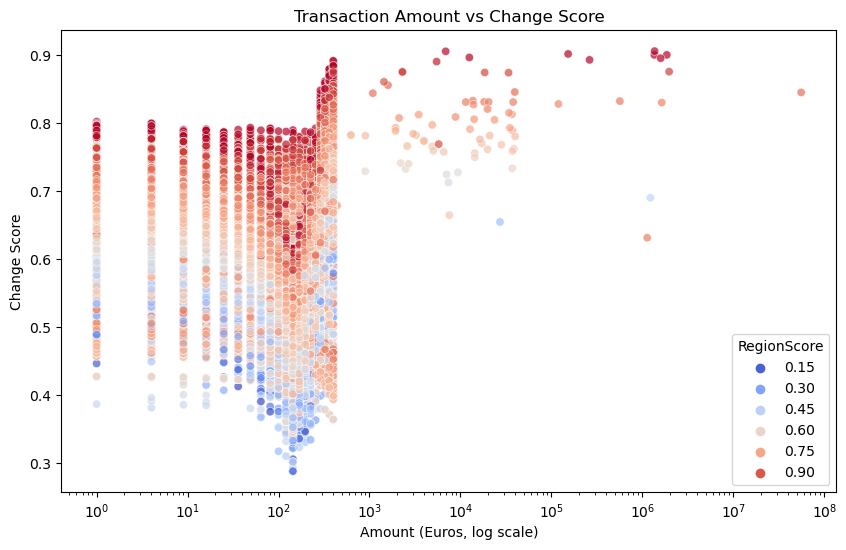

In [118]:
#top_txn = trnx_final.sort_values("ChangeScore", ascending=False).head(10)
os.makedirs("plots", exist_ok=True)

plt.figure(figsize=(10,6))
sns.scatterplot(
    x="Amount_in_euros",
    y="ChangeScore",
    data=trnx_final,
    hue="RegionScore",
    palette="coolwarm",
    alpha=0.7
)
plt.yscale('linear')
plt.xscale('log')  # if amounts vary widely
plt.title("Transaction Amount vs Change Score")
plt.xlabel("Amount (Euros, log scale)")
plt.ylabel("Change Score")
# Save the figure
plt.savefig("plots/transactionAmountVSChangeScore.png", bbox_inches='tight', dpi=300)
plt.show()

C:\Users\Sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


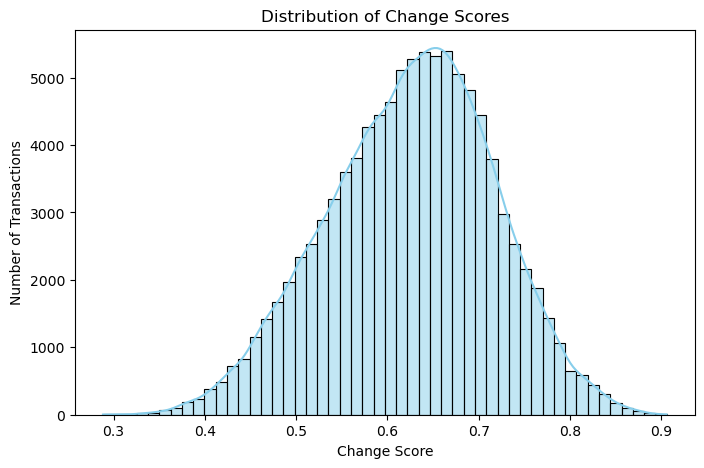

In [119]:
change_scores = trnx_final["ChangeScore"].replace([np.inf, -np.inf], np.nan)

# Optional: drop NaN
change_scores = change_scores.dropna()

# Plot histogram
plt.figure(figsize=(8,5))
sns.histplot(change_scores, bins=50, kde=True, color='skyblue')
plt.title("Distribution of Change Scores")
plt.xlabel("Change Score")
plt.ylabel("Number of Transactions")
# Save the figure
plt.savefig("plots/ditribution_of_changescore.png", bbox_inches='tight', dpi=300)
plt.show()

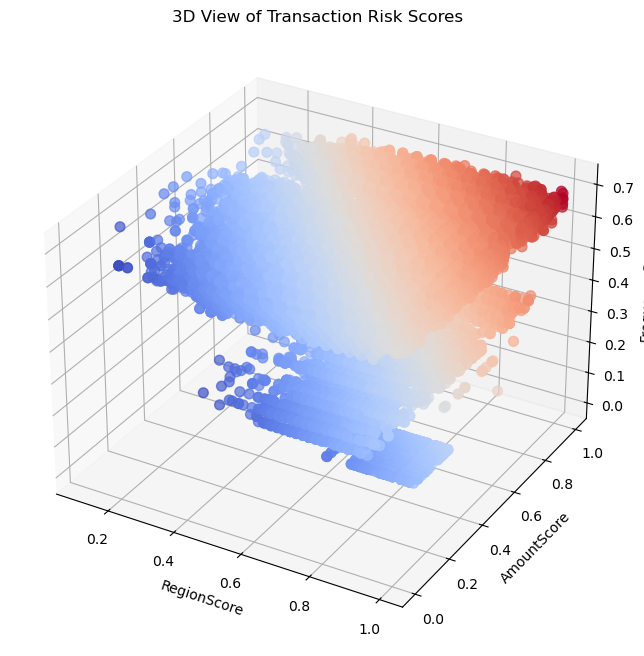

In [120]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    trnx_final["RegionScore"],
    trnx_final["AmountScore"],
    trnx_final["FrequencyScore"],
    c=trnx_final["ChangeScore"],
    cmap="coolwarm",
    s=50,
    alpha=0.7
)
ax.set_xlabel("RegionScore")
ax.set_ylabel("AmountScore")
ax.set_zlabel("FrequencyScore")
plt.title("3D View of Transaction Risk Scores")
# Save the figure
plt.savefig("plots/riskScoreTransactions.png", bbox_inches='tight', dpi=300)
plt.show()

In [121]:
print(os.listdir("output"))  # should show ChangeScore_output.csv
print(os.listdir("plots"))   # should show top_transactions.png

['ChangeScore_output.csv']
['ditribution_of_changescore.png', 'riskScoreTransactions.png', 'top_transactions.png', 'transactionAmountVSChangeScore.png']
